# Data Cleaning and Exploratory Data Analysis

This notebook performs data cleaning and exploratory data analysis on the electric vehicle charging stations dataset.


In [1]:
# Install required libraries (uncomment if needed)
# !pip install geopandas pandas matplotlib seaborn


In [2]:
# Import required libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Step 1: Read GeoJSON File


In [3]:
# Read the GeoJSON file
gdf = gpd.read_file("Elektrikli Araç Şarj İstasyonları Verisi.geojson")

print(f"Total number of stations: {len(gdf)}")
print(f"\nColumns in the dataset:")
print(gdf.columns.tolist())


Total number of stations: 2933

Columns in the dataset:
['ISTASYON_NO', 'AD', 'ADRES', 'DAGITIM_SIRKETI_LISANS_NO', 'DAGITIM_SIRKETI_LISANS_SAHIBI', 'HIZMET_SEKLI', 'AGIL_ISLETMECISI_UNVAN', 'MARKA_TESCIL_BELGESI', 'LONGITUDE', 'LATITUDE', 'geometry']


## Step 2: Select and Rename Columns


In [4]:
# Select only the required columns
columns_to_keep = [
    'ISTASYON_NO',
    'AD',
    'ADRES',
    'AGIL_ISLETMECISI_UNVAN',
    'MARKA_TESCIL_BELGESI',
    'LATITUDE',
    'LONGITUDE'
]

# Create a new DataFrame with selected columns
df = gdf[columns_to_keep].copy()

# Rename columns
df.rename(columns={
    'AGIL_ISLETMECISI_UNVAN': 'operator',
    'MARKA_TESCIL_BELGESI': 'brand'
}, inplace=True)

print("Columns after selection and renaming:")
print(df.columns.tolist())


Columns after selection and renaming:
['ISTASYON_NO', 'AD', 'ADRES', 'operator', 'brand', 'LATITUDE', 'LONGITUDE']


## Step 3: Add 'side' Column (Europe/Asia)


In [5]:
# Add 'side' column based on longitude
# Istanbul's Bosphorus is approximately at longitude 29°
# If LONGITUDE < 29, then it's on the European side, else Asian side
df['side'] = df['LONGITUDE'].apply(lambda x: 'Europe' if x < 29 else 'Asia')

print("Side distribution:")
print(df['side'].value_counts())


Side distribution:
side
Europe    1605
Asia      1328
Name: count, dtype: int64


## Step 4: Basic EDA


In [6]:
# Display first few rows
print("First 5 rows:")
print(df.head())


First 5 rows:
  ISTASYON_NO                                                AD  \
0    ŞRJ/2140  KMO FENERKÖY KUZEY OHT1, KMO FENERKÖY KUZEY OHT2   
1    ŞRJ/2672                                      CAROUSEL AVM   
2    ŞRJ/2803                            SERENİTY COMFORT HOTEL   
3    ŞRJ/2804                                        MAYİ HOTEL   
4    ŞRJ/2859                             THE İSTANBUL REZİDANS   

                                               ADRES  \
0  Ali Paşa Mahallesi Merkez Saray Sokağı  Y: 351...   
1  Zeytinlik Mahallesi Halit Uşaklıgil Caddesi  N...   
2  Mahmutbey Mahallesi Payami Safa Caddesi  No:16...   
3  Mahmutbey Mahallesi Payami Safa Caddesi  No:25...   
4  Sümer Mahallesi Pr.dr. Turan Güneş Caddesi  No...   

                                      operator    brand   LATITUDE  LONGITUDE  \
0  BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ  beefull  41.121918  28.228961   
1  BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ  beefull  40.977462  28.872781   
2  

In [7]:
# Display basic information
print("DataFrame Info:")
print(df.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ISTASYON_NO  2933 non-null   object 
 1   AD           2933 non-null   object 
 2   ADRES        2933 non-null   object 
 3   operator     2933 non-null   object 
 4   brand        2933 non-null   object 
 5   LATITUDE     2933 non-null   float64
 6   LONGITUDE    2933 non-null   float64
 7   side         2933 non-null   object 
dtypes: float64(2), object(6)
memory usage: 183.4+ KB
None


In [8]:
# Check for missing values
print("Missing values:")
print(df.isna().sum())


Missing values:
ISTASYON_NO    0
AD             0
ADRES          0
operator       0
brand          0
LATITUDE       0
LONGITUDE      0
side           0
dtype: int64


In [9]:
# Value counts for operator
print("Operator distribution:")
print(df['operator'].value_counts())


Operator distribution:
operator
ZES DİJİTAL TİCARET ANONİM ŞİRKETİ                                             281
VOLTRUN ENERJİ ANONİM ŞİRKETİ                                                  276
EŞARJ ELEKTRİKLİ ARAÇLAR ŞARJ SİSTEMLERİ ANONİM ŞİRKETİ                        161
BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ                                    142
ZEPLİN TURİZM ARAÇ KİRALAMA MOBİLİTE VE ENERJİ YATIRIMLARI ANONİM ŞİRKETİ      125
                                                                              ... 
SKY WORLD SOLAR ENERJİ ANONIM ŞİRKETİ                                            1
FZY ENERJİ ŞARJ SİSTEMLERİ ANONİM ŞİRKETİ                                        1
KOÇASLANLAR AKARYAKIT ENERJİ PETROL ÜRÜNLERİ SANAYİ TİCARET LİMİTED ŞİRKETİ      1
DUMANOĞLU ENERJİ YATIRIM ANONİM ŞİRKETİ                                          1
YENİ MODEL YAPAY ZEKA VE ROBOTİK TEKNOLOJİ HİZMETLERİ ANONİM ŞİRKETİ             1
Name: count, Length: 133, dtype: int64


In [10]:
# Value counts for side
print("Side distribution:")
print(df['side'].value_counts())


Side distribution:
side
Europe    1605
Asia      1328
Name: count, dtype: int64


## Step 5: Visualizations


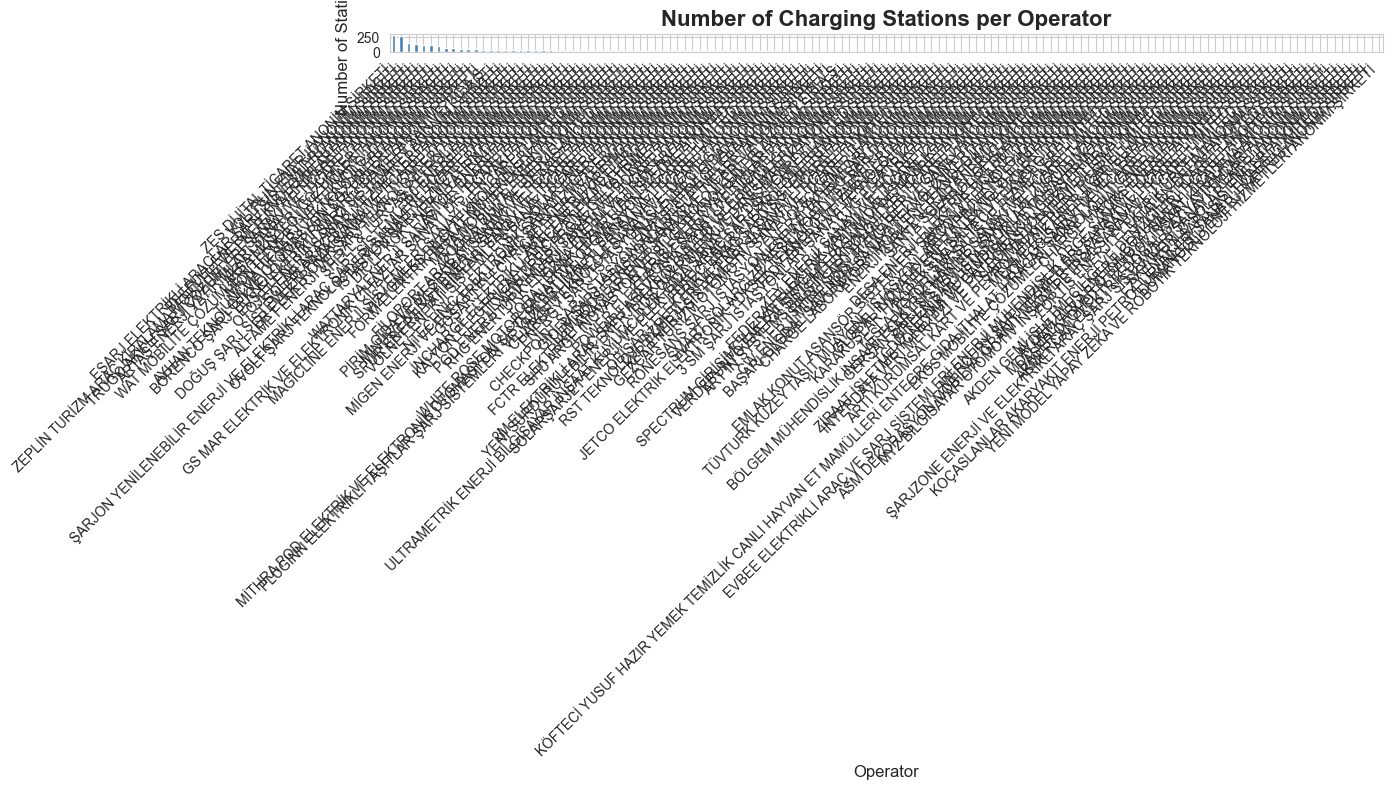


Total number of unique operators: 133


In [11]:
# Bar chart: Number of stations per operator
operator_counts = df['operator'].value_counts()

plt.figure(figsize=(14, 8))
operator_counts.plot(kind='bar', color='steelblue')
plt.title('Number of Charging Stations per Operator', fontsize=16, fontweight='bold')
plt.xlabel('Operator', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nTotal number of unique operators: {df['operator'].nunique()}")


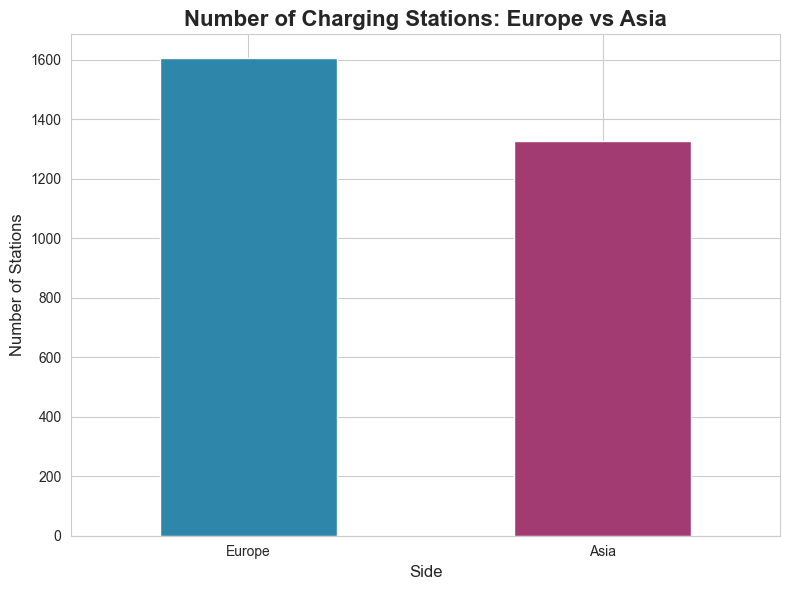


Europe: 1605 stations
Asia: 1328 stations


In [12]:
# Bar chart: Number of stations per side (Europe vs Asia)
side_counts = df['side'].value_counts()

plt.figure(figsize=(8, 6))
side_counts.plot(kind='bar', color=['#2E86AB', '#A23B72'])
plt.title('Number of Charging Stations: Europe vs Asia', fontsize=16, fontweight='bold')
plt.xlabel('Side', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nEurope: {side_counts.get('Europe', 0)} stations")
print(f"Asia: {side_counts.get('Asia', 0)} stations")


## Step 6: Save Cleaned Data to CSV


In [13]:
# Save cleaned DataFrame to CSV
df.to_csv('cleaned_stations.csv', index=False, encoding='utf-8')
print("Cleaned data saved to 'cleaned_stations.csv'")
print(f"Total rows saved: {len(df)}")


Cleaned data saved to 'cleaned_stations.csv'
Total rows saved: 2933
